In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


## import Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 1 - Data preparation

### 1.1 - Load Data

In [9]:
# Load the data
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

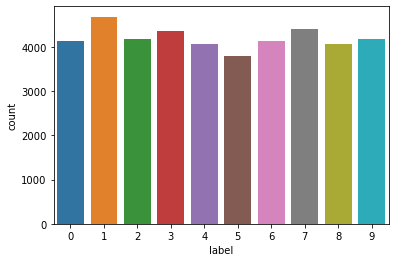

In [10]:
Y_train = train_data["label"]

# Drop 'label' column
X_train = train_data.drop(labels = ["label"],axis = 1) 

# free some space
del train_data 

g = sns.countplot(Y_train)

Y_train.value_counts()

### 1.2 - Check for null and missing values

In [11]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 1.3 - Normalization

In [13]:
# Normalize the data
X_train = X_train / 255.0
test_data = test_data / 255.0

### 1.4 - Reshape

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

### 1.5 - Label encoding

In [15]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

### 1.6 - Split training and valdiation set

In [16]:
# Set the random seed
random_seed = 2

In [17]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

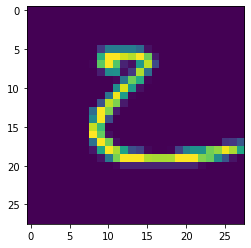

In [18]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

## 2 - Define the Neural Network

### 2.1 - Build the model

In [19]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

### 2.2 - Set the optimizer 

In [21]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
epochs = 50 
batch_size = 64

### 2.3 - Data Augmentation

In [24]:
# Data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(X_train)

In [25]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/50
525/525 - 13s - loss: 0.4162 - accuracy: 0.8666 - val_loss: 0.0741 - val_accuracy: 0.9761
Epoch 2/50
525/525 - 12s - loss: 0.1326 - accuracy: 0.9609 - val_loss: 0.0422 - val_accuracy: 0.9860
Epoch 3/50
525/525 - 12s - loss: 0.0982 - accuracy: 0.9702 - val_loss: 0.0420 - val_accuracy: 0.9871
Epoch 4/50
525/525 - 13s - loss: 0.0863 - accuracy: 0.9751 - val_loss: 0.0407 - val_accuracy: 0.9874
Epoch 5/50
525/525 - 12s - loss: 0.0772 - accuracy: 0.9776 - val_loss: 0.0450 - val_accuracy: 0.9874
Epoch 6/50
525/525 - 12s - loss: 0.0690 - accuracy: 0.9795 - val_loss: 0.0279 - val_accuracy: 0.9921
Epoch 7/50
525/525 - 12s - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.0316 - val_accuracy: 0.9900
Epoch 8/50
525/525 - 13s - loss: 0.0646 - accuracy: 0.9819 - val_loss: 0.0409 - val_accuracy: 0.9888
Epoch 9/50
525/525 - 13s - loss: 0.0616 - accuracy: 0.9829 - val_loss: 0.0301 - val_accuracy: 0.9919
Epoch 10/50
525/525 - 12s - loss: 0.0635 - accuracy: 0.9825 - val_loss: 0.0258 - val_accura

## 3 - Evaluate the model

In [26]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.416228,0.866577,0.074106,0.976071
1,0.132612,0.960863,0.042246,0.985952
2,0.098195,0.970208,0.041980,0.987143
3,0.086313,0.975119,0.040748,0.987381
4,0.077231,0.977560,0.045016,0.987381
5,0.069007,0.979524,0.027917,0.992143
6,0.066341,0.981042,0.031584,0.990000
7,0.064557,0.981875,0.040949,0.988810
8,0.061598,0.982857,0.030079,0.991905
9,0.063515,0.982470,0.025751,0.992262


### 3.1 - Training and validation curves

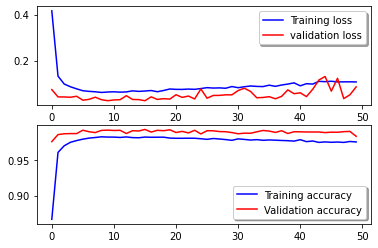

In [27]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [28]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9756249785423279
validation_accuracy 0.9835714101791382


### 3.2 - Confusion matrix

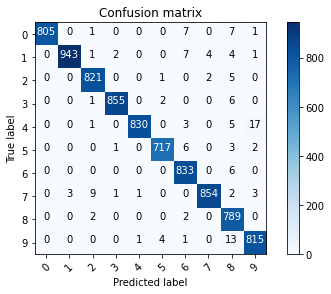

In [30]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

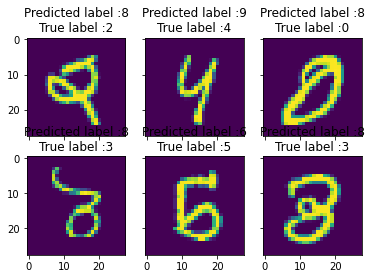

In [31]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Prediction:
3


<function matplotlib.pyplot.show(*args, **kw)>

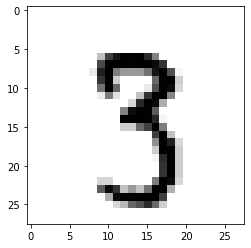

In [33]:
np.random.seed(22)
random_selection = np.random.randint(0,4201,size=1)
random_sample = X_val[random_selection]
print('Prediction:')
print(model.predict_classes(random_sample.reshape(1,28,28,1))[0])
plt.imshow(random_sample.reshape(28,28),cmap='binary')
plt.show

Prediction:
0


<function matplotlib.pyplot.show(*args, **kw)>

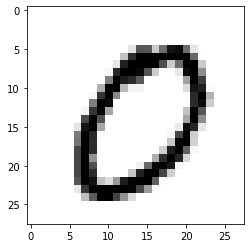

In [34]:
np.random.seed(20)
random_selection=np.random.randint(0,4201,size=1)
random_sample = X_val[random_selection]
print('Prediction:')
print(model.predict_classes(random_sample.reshape(1,28,28,1))[0])
plt.imshow(random_sample.reshape(28,28),cmap='binary')
plt.show